# Optimizing UBI policy with a 40% flat income tax

Start with a 40% flat income tax, eliminating all deductions, credits, and non-health benefit programs. Take that pile of money and adapt the amounts per age group to optimize for disruption.

*Data: CPS  |  Tax year: 2019  |  Type: Static  |  Author: Max Ghenis*

## Setup

### Imports

In [176]:
import taxcalc as tc
import taxcalc_helpers as tch
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import skopt
from skopt import plots as skopt_plots

In [2]:
tc.__version__

'2.2.0'

### Constants

In [296]:
FIT = 0.5
YEAR = 2019

### Settings

In [297]:
sns.set_style('white')
DPI = 200
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.

In [298]:
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

In [299]:
# Show one decimal in tables.
pd.set_option('precision', 2)

### Function to set all tax rates to the same value

In [300]:
def rt(rate, year=YEAR):
    return {year: rate}

In [301]:
RT_ZERO = rt(0)
RT_ONE = rt(1)
RT_ZEROS = rt([0, 0, 0, 0, 0])

In [302]:
REPEAL_DEDUCTIONS_REFORM = {
    'STD': RT_ZEROS,
    'ID_c': RT_ZEROS
}

In [303]:
REPEAL_CREDITS_REFORM = {
    'EITC_c': rt([0, 0, 0, 0]),  # Don't use RT_ZEROS as that's 5 items.
    'CTC_c': RT_ZERO,
    'ACTC_c': RT_ZERO,
    'ODC_c': RT_ZERO,
    'CDCC_c': RT_ZERO,
    'CR_RetirementSavings_hc': RT_ONE,
    'CR_ForeignTax_hc': RT_ONE,
    'CR_ResidentialEnergy_hc': RT_ONE,
    'CR_GeneralBusiness_hc': RT_ONE,
    'CR_MinimumTax_hc': RT_ONE,
    'CR_AmOppRefundable_hc': RT_ONE,
    'CR_AmOppNonRefundable_hc': RT_ONE,
    'CR_SchR_hc': RT_ONE,
    'CR_OtherCredits_hc': RT_ONE,
    'CR_Education_hc': RT_ONE
}

Exclude Medicaid and Medicare from both baseline and reform.

In [304]:
MCAID_MCARE_REPEAL_REFORM = {
    'BEN_mcaid_repeal': rt(True),
    'BEN_mcare_repeal': rt(True),
}

In [305]:
REPEAL_BENEFITS_REFORM = {
    'BEN_ssi_repeal': rt(True),
    'BEN_housing_repeal': rt(True),
    'BEN_snap_repeal': rt(True),
    'BEN_vet_repeal': rt(True),
    'BEN_wic_repeal': rt(True),
    'BEN_oasdi_repeal': rt(True),
    'BEN_ui_repeal': rt(True),
    'BEN_other_repeal': rt(True)
}

In [352]:
REPEAL_PAYROLL_TAX_REFORM = {
    'FICA_ss_trt': RT_ZERO,
    'FICA_mc_trt': RT_ZERO,
    'AMEDT_rt': RT_ZERO
}

In [306]:
def create_fit_reform(rate):
    return {
        'II_rt1': rt(rate),
        'II_rt2': rt(rate),
        'II_rt3': rt(rate),
        'II_rt4': rt(rate),
        'II_rt5': rt(rate),
        'II_rt6': rt(rate),
        'II_rt7': rt(rate),
        'II_rt8': rt(rate),
        'PT_rt1': rt(rate),
        'PT_rt2': rt(rate),
        'PT_rt3': rt(rate),
        'PT_rt4': rt(rate),
        'PT_rt5': rt(rate),
        'PT_rt6': rt(rate),
        'PT_rt7': rt(rate),
        'PT_rt8': rt(rate),
        'CG_nodiff': {2019: True},  # Avoid specifying each CG rate.
        'AMT_rt1': rt(rate),
        'AMT_rt2': rt(0)  # This is the excess rate. Ideally remove AMT.
    }

In [307]:
base_reform = MCAID_MCARE_REPEAL_REFORM

TODO: Add payroll taxes.

In [353]:
fit_reform = create_fit_reform(FIT)
fit_reform.update(MCAID_MCARE_REPEAL_REFORM)
fit_reform.update(REPEAL_BENEFITS_REFORM)
fit_reform.update(REPEAL_DEDUCTIONS_REFORM)
fit_reform.update(REPEAL_CREDITS_REFORM)
fit_reform.update(REPEAL_PAYROLL_TAX_REFORM)

In [354]:
fit_reform

{'II_rt1': {2019: 0.5},
 'II_rt2': {2019: 0.5},
 'II_rt3': {2019: 0.5},
 'II_rt4': {2019: 0.5},
 'II_rt5': {2019: 0.5},
 'II_rt6': {2019: 0.5},
 'II_rt7': {2019: 0.5},
 'II_rt8': {2019: 0.5},
 'PT_rt1': {2019: 0.5},
 'PT_rt2': {2019: 0.5},
 'PT_rt3': {2019: 0.5},
 'PT_rt4': {2019: 0.5},
 'PT_rt5': {2019: 0.5},
 'PT_rt6': {2019: 0.5},
 'PT_rt7': {2019: 0.5},
 'PT_rt8': {2019: 0.5},
 'CG_nodiff': {2019: True},
 'AMT_rt1': {2019: 0.5},
 'AMT_rt2': {2019: 0},
 'BEN_mcaid_repeal': {2019: True},
 'BEN_mcare_repeal': {2019: True},
 'BEN_ssi_repeal': {2019: True},
 'BEN_housing_repeal': {2019: True},
 'BEN_snap_repeal': {2019: True},
 'BEN_vet_repeal': {2019: True},
 'BEN_wic_repeal': {2019: True},
 'BEN_oasdi_repeal': {2019: True},
 'BEN_ui_repeal': {2019: True},
 'BEN_other_repeal': {2019: True},
 'STD': {2019: [0, 0, 0, 0, 0]},
 'ID_c': {2019: [0, 0, 0, 0, 0]},
 'EITC_c': {2019: [0, 0, 0, 0]},
 'CTC_c': {2019: 0},
 'ACTC_c': {2019: 0},
 'ODC_c': {2019: 0},
 'CDCC_c': {2019: 0},
 'CR_Retirem

## Data

In [355]:
recs = tc.Records.cps_constructor()

Note, don't use `XTOT` because it doesn't match the age variables.

In [356]:
base = tch.calc_df(records=recs, reform=base_reform, year=YEAR, 
                   group_vars=['nu18', 'n1820', 'n21'], group_n65=True,
                   metric_vars=['aftertax_income'])

In [357]:
fit = tch.calc_df(records=recs, reform=fit_reform, year=YEAR, 
                  group_vars='XTOT', metric_vars='aftertax_income')

CTC_c was redefined in release 1.0.0



In [358]:
new_rev_m = (base.aftertax_income_m.sum() - fit.aftertax_income_m.sum())
'This reform would raise $' + str(round(new_rev_m / 1e6, 2)) + 'T.'

'This reform would raise $5.24T.'

Fix person counts to account for `n65>n21` (see [taxdata#317](https://github.com/PSLmodels/taxdata/issues/317)).

In [359]:
base.n21 = base[['n21', 'n65']].max(axis=1)

Define new exclusive age categories for UBI.

In [360]:
base['n'] = base[['nu18', 'n1820', 'n21']].sum(axis=1)
base['n1864'] = base.n - base.nu18 - base.n65

Weight metrics.

In [361]:
tch.add_weighted_metrics(base, ['n', 'nu18', 'n1864', 'n65'])

In [362]:
single_ubi = new_rev_m / base.n_m.sum()
'This reform would fund a single UBI of $' + str(int(round(single_ubi))) + '.'

'This reform would fund a single UBI of $15731.'

In [391]:
n_total_m = base.n_m.sum()

## Functions for simulating UBI

In [363]:
fit.columns

Index(['ssi_ben', 'other_ben', 'XTOT', 's006', 'vet_ben', 'e02300', 'snap_ben',
       'housing_ben', 'expanded_income', 'mcaid_ben', 'tanf_ben', 'e02400',
       'wic_ben', 'mcare_ben', 'aftertax_income', 'market_income', 'bens',
       'tax', 's006_m', 'aftertax_income_m'],
      dtype='object')

In [364]:
br = base.join(fit[['aftertax_income']], lsuffix='_base', rsuffix='_reform')

In [386]:
br['fpl_base_n_m'] = (
    br.aftertax_income_base < tch.fpl(br.n)) * br.n_m

In [366]:
nu18_total_m = br.nu18_m.sum()
n1864_total_m = br.n1864_m.sum()
n65_total_m = br.n65_m.sum()

In [367]:
def calc_ubi_1864(ubi_u18, ubi_65):
    ubi_u18_total_m = ubi_u18 * nu18_total_m
    ubi_65_total_m = ubi_65 * n65_total_m
    ubi_1864_total_m = new_rev_m - ubi_u18_total_m - ubi_65_total_m
    return ubi_1864_total_m / n1864_total_m

Verify that the 18-64 UBI level is the single UBI when the u18 and 65+ UBI levels are both the single UBI.

In [368]:
np.allclose(calc_ubi_1864(single_ubi, single_ubi), single_ubi)

True

In [369]:
def ubi(nu18, ubi_u18, n1864, ubi_1864, n65, ubi_65):
    return (nu18 * ubi_u18) + (n1864 * ubi_1864) + (n65 * ubi_65)

In [370]:
br_slim = br[['nu18', 'n1864', 'n65', 'n', 'n_m', 's006',
              'aftertax_income_base', 'aftertax_income_reform']]

In [394]:
def ubi_sim(ubi_u18, ubi_65):
    res = br_slim.copy(deep=True)
    ubi_1864 = calc_ubi_1864(ubi_u18, ubi_65)
    res['ubi'] = ubi(res.nu18, ubi_u18, res.n1864, ubi_1864, res.n65, ubi_65)
    res.aftertax_income_reform = res.aftertax_income_reform + res.ubi
    res.aftertax_income_noneg_base = np.maximum(res.aftertax_income_base, 0)
    res['aftertax_income_chg'] = (res.aftertax_income_reform -
                                  res.aftertax_income_base)
    # Check for zeros to avoid 0/0 NaNs.
    res['aftertax_income_pctchg'] = np.where(
        res.aftertax_income_chg == 0, 0,
        res.aftertax_income_chg / res.aftertax_income_noneg_base)
    res['winners_n_m'] = (res.aftertax_income_chg > 0) * res.n_m
    res['fpl_reform_n_m'] = (
        res.aftertax_income_reform < tch.fpl(res.n)) * res.n_m
    return res

In [372]:
def share_losers(ubi_u18, ubi_65):
    # Check that the resulting UBI is nonnegative.
    # Returning 1 ensures it won't be chosen as a solution.
    if calc_ubi_1864(ubi_u18, ubi_65) < 0:
        return 1
    sim = ubi_sim(ubi_u18, ubi_65)
    return 1 - sim.winners_n_m.sum() / n_total_m

In [373]:
def share_losers_skopt(ubi_list):
    # Take args as a list: [ubi_u18, ubi_65]
    return share_losers(ubi_list[0], ubi_list[1])

In [374]:
def share_big_losers(ubi_u18, ubi_65):
    # Check that the resulting UBI is nonnegative.
    # Returning 1 ensures it won't be chosen as a solution.
    if calc_ubi_1864(ubi_u18, ubi_65) < 0:
        return 1
    sim = ubi_sim(ubi_u18, ubi_65)
    sim['big_losers_n_m'] = (sim.aftertax_income_pctchg < -0.05) * sim.n_m
    return sim.big_losers_n_m.sum() / n_total_m

In [375]:
def share_big_losers_skopt(ubi_list):
    # Take args as a list: [ubi_u18, ubi_65]
    return share_big_losers(ubi_list[0], ubi_list[1])

In [376]:
def neg_median_income(ubi_u18, ubi_65):
    # Check that the resulting UBI is nonnegative.
    # Returning 1 ensures it won't be chosen as a solution.
    if calc_ubi_1864(ubi_u18, ubi_65) < 0:
        return 1
    sim = ubi_sim(ubi_u18, ubi_65)
    return -tch.weighted_quantile(sim.aftertax_income_reform, 0.5, 
                                  sim.n)

In [377]:
def neg_median_income_skopt(ubi_list):
    # Take args as a list: [ubi_u18, ubi_65]
    return neg_median_income(ubi_list[0], ubi_list[1])

In [430]:
def inequality(ubi_u18, ubi_65):
    if calc_ubi_1864(ubi_u18, ubi_65) < 0:
        return 1
    sim = ubi_sim(ubi_u18, ubi_65)
    return tch.gini(sim.aftertax_income_reform, sim.n_m)

In [431]:
def inequality_skopt(ubi_list):
    return inequality(ubi_list[0], ubi_list[1])

## Run a single UBI

In [395]:
sim_single = ubi_sim(single_ubi, single_ubi)

/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


### Calculate baseline metrics

In [389]:
gini_base = tch.gini(sim_single.aftertax_income_base, sim_single.n_m)

In [392]:
fpl_base = br.fpl_base_n_m.sum() / n_total_m
fpl_base

0.07287553699023902

In [399]:
median_income_base = tch.weighted_quantile(base.aftertax_income, 0.5, base.n_m)
median_income_base

56093.083837944105

### Calculate single-UBI reform metrics

In [402]:
tch.gini(sim_single.aftertax_income_reform, sim_single.n_m) / gini_base - 1

-0.19062674769957966

In [403]:
(sim_single.fpl_reform_n_m.sum() / n_total_m) / fpl_base - 1

-0.9958314075598907

In [404]:
(tch.weighted_quantile(sim_single.aftertax_income_reform, 0.5,
                       sim_single.n_m) / median_income_base) - 1

0.3126355519694608

In [417]:
share_losers(single_ubi, single_ubi)

/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


0.3454688269179784

In [418]:
share_big_losers(single_ubi, single_ubi)

/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


0.294314691636624

## Optimize

Use 3 different optimization routines.

In [410]:
calc_ubi_1864(38000, 38000)

562.2592184290353

In [411]:
UBI_MAX = 38000  # Beyond this and you start to get negatives.
param = (0., UBI_MAX)  # Don't set a prior as this ratholes the routines.
params = [param, param]

In [412]:
%%capture
# Hide the many warnings that a solution has already been evaluated.
gbrt_losers = skopt.gbrt_minimize(share_losers_skopt, params, n_jobs=-1)
gbrt_big_losers = skopt.gbrt_minimize(share_big_losers_skopt, params,
                                      n_jobs=-1)
# Others don't do as well.
# gp_res = skopt.gp_minimize(share_losers_skopt, params, n_jobs=-1)
# forest_res = skopt.forest_minimize(share_losers_skopt, params, n_jobs=-1)
# dummy_res = skopt.dummy_minimize(share_losers_skopt, params)

In [432]:
%%capture
# Hide the many warnings that a solution has already been evaluated.
gbrt_inequality = skopt.gbrt_minimize(inequality_skopt, params, n_jobs=-1)
# Others don't do as well.
# gp_res = skopt.gp_minimize(share_losers_skopt, params, n_jobs=-1)
# forest_res = skopt.forest_minimize(share_losers_skopt, params, n_jobs=-1)
# dummy_res = skopt.dummy_minimize(share_losers_skopt, params)

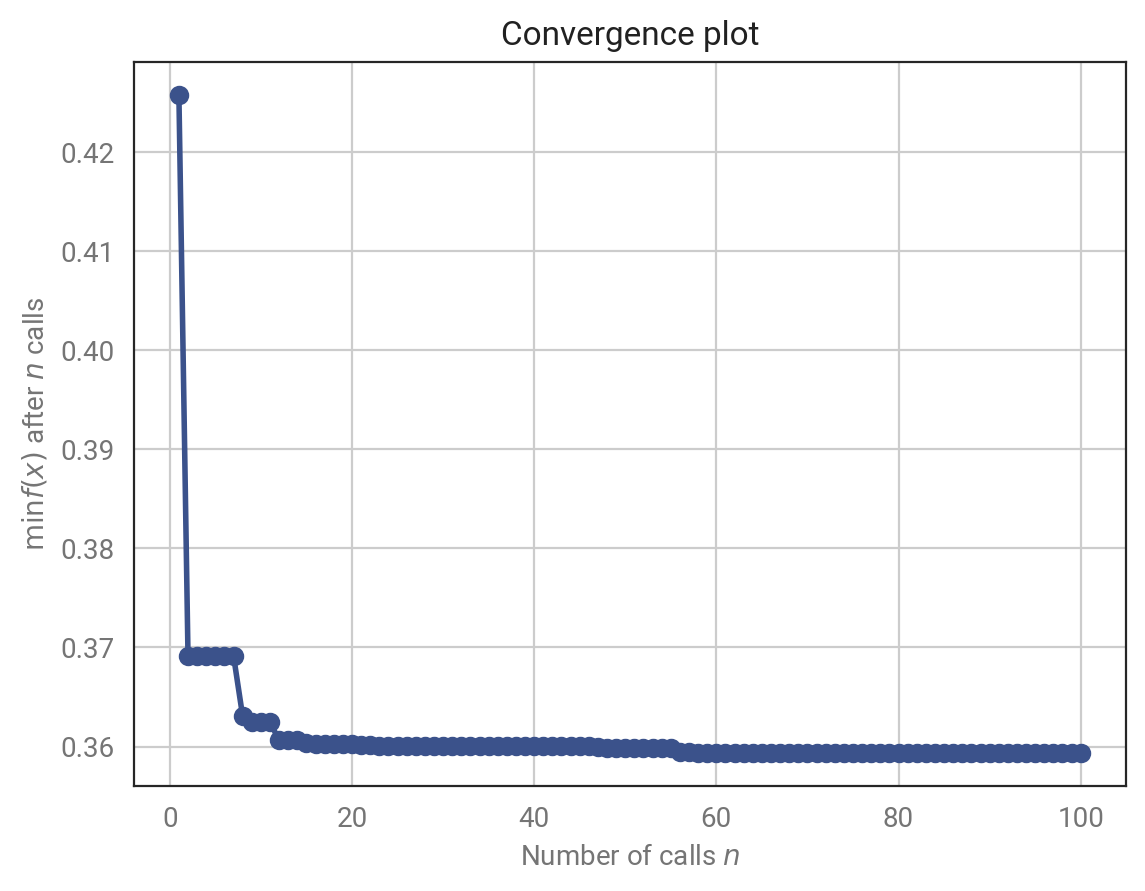

In [433]:
skopt_plots.plot_convergence(gbrt_inequality)  #, gp_res, forest_res, dummy_res)
# plt.ylim([0.3, 0.32])
# plt.legend(['gbrt', 'gp', 'forest', 'dummy'])
plt.show()

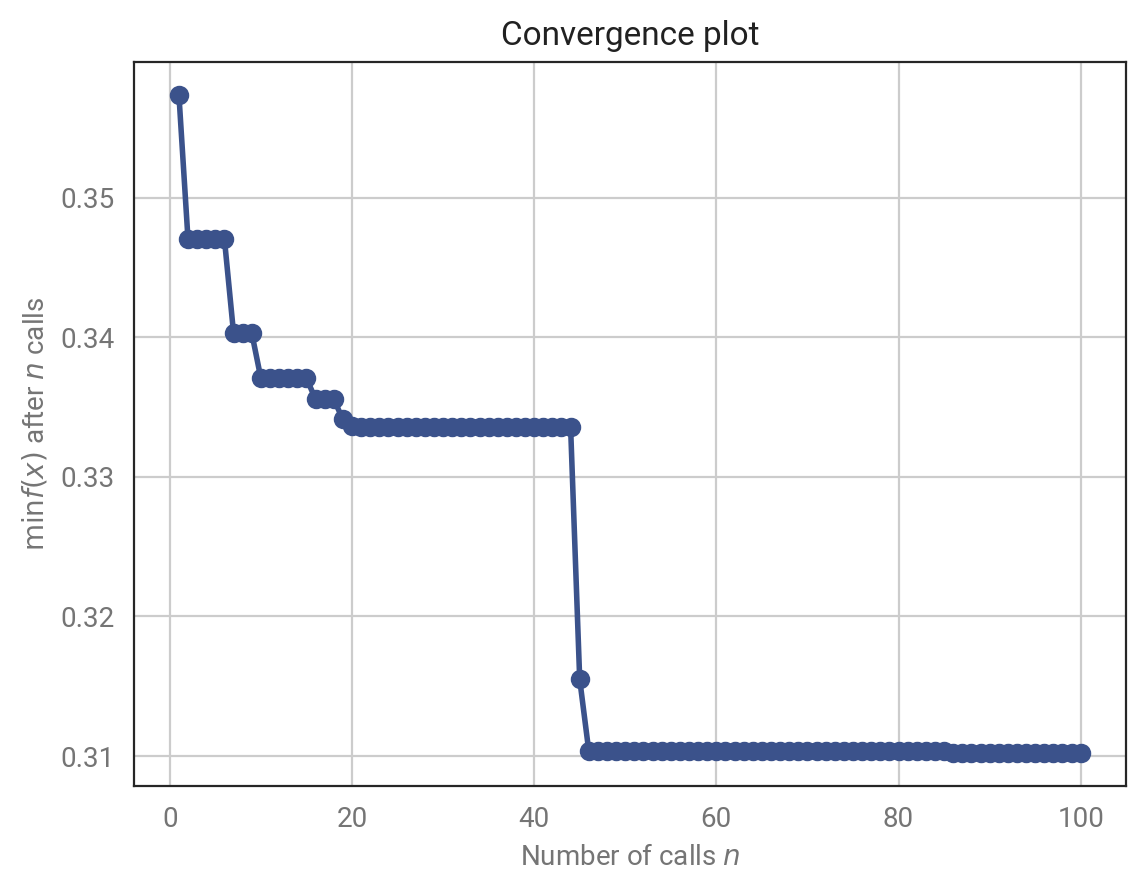

In [413]:
skopt_plots.plot_convergence(gbrt_res)  #, gp_res, forest_res, dummy_res)
# plt.ylim([0.3, 0.32])
# plt.legend(['gbrt', 'gp', 'forest', 'dummy'])
plt.show()

To beat: 31.63

In [421]:
gbrt_res.fun

0.31018633538788953

In [420]:
gbrt_res.x

[10709.846385450235, 2294.911912772724]

In [419]:
# pd.Series([gbrt_res.fun, gp_res.fun, forest_res.fun, dummy_res.fun],
#           index=['gbrt', 'gp', 'forest', 'dummy']) * 100

In [422]:
sim_losers = ubi_sim(gbrt_res.x[0], gbrt_res.x[1])

/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [427]:
tch.gini(sim_losers.aftertax_income_reform, sim_losers.n_m) / gini_base - 1

-0.1633856177093035

In [426]:
(sim_losers.fpl_reform_n_m.sum() / n_total_m) / fpl_base - 1

-0.2191556515852937

In [425]:
(tch.weighted_quantile(sim_losers.aftertax_income_reform, 0.5,
                       sim_losers.n_m) / median_income_base) - 1

0.32624391039612854

In [428]:
share_losers(gbrt_res.x[0], gbrt_res.x[1])

/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


0.31018633538788953

In [429]:
share_big_losers(gbrt_res.x[0], gbrt_res.x[1])

/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


0.2680379705423772

In [416]:
calc_ubi_1864(gbrt_res.x[0], gbrt_res.x[1])

21249.691764846168

### Optimizing for inequality

In [435]:
gbrt_inequality.fun / gini_base

0.7833055797940651

In [436]:
gbrt_inequality.x

[6140.9299070535435, 25310.367485041374]

In [437]:
calc_ubi_1864(gbrt_inequality.x[0], gbrt_inequality.x[1])

17481.461773622803

In [419]:
# pd.Series([gbrt_res.fun, gp_res.fun, forest_res.fun, dummy_res.fun],
#           index=['gbrt', 'gp', 'forest', 'dummy']) * 100

In [439]:
sim_inequality = ubi_sim(gbrt_inequality.x[0], gbrt_inequality.x[1])

/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [441]:
tch.gini(sim_inequality.aftertax_income_reform, sim_inequality.n_m) / gini_base - 1

-0.21669442020593488

In [440]:
(sim_inequality.fpl_reform_n_m.sum() / n_total_m) / fpl_base - 1

-0.940015390023747

In [442]:
(tch.weighted_quantile(sim_inequality.aftertax_income_reform, 0.5,
                       sim_inequality.n_m) / median_income_base) - 1

0.2093295132336075

In [443]:
share_losers(gbrt_inequality.x[0], gbrt_inequality.x[1])

/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


0.35242964140881894

In [444]:
share_big_losers(gbrt_inequality.x[0], gbrt_inequality.x[1])

/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


0.27889097244181504